In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import tensorflow
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adamax
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam,Adadelta,RMSprop,Adagrad
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import numpy as np
import argparse
import cv2

from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
import scipy
import skimage
from skimage.transform import resize
import random
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/covid3/covid3/normal/IM-0531-0001-0001.jpeg
/kaggle/input/covid3/covid3/normal/NORMAL2-IM-0899-0001.jpeg
/kaggle/input/covid3/covid3/normal/NORMAL2-IM-0936-0001.jpeg
/kaggle/input/covid3/covid3/normal/NORMAL2-IM-0908-0001.jpeg
/kaggle/input/covid3/covid3/normal/IM-0103-0001.jpeg
/kaggle/input/covid3/covid3/normal/IM-0501-0001.jpeg
/kaggle/input/covid3/covid3/normal/NORMAL2-IM-0391-0001.jpeg
/kaggle/input/covid3/covid3/normal/IM-0036-0001.jpeg
/kaggle/input/covid3/covid3/normal/IM-0439-0001.jpeg
/kaggle/input/covid3/covid3/normal/IM-0503-0001.jpeg
/kaggle/input/covid3/covid3/normal/NORMAL2-IM-0976-0001.jpeg
/kaggle/input/covid3/covid3/normal/NORMAL2-IM-0798-0001.jpeg
/kaggle/input/covid3/covid3/normal/IM-0243-0001.jpeg
/kaggle/input/covid3/covid3/normal/IM-0497-0001-0001.jpeg
/kaggle/input/covid3/covid3/normal/NORMAL2-IM-0851-0001-0002.jpeg
/kaggle/input/covid3/covid3/normal/IM-0255-0001.jpeg
/kaggle/input/covid3/covid3/normal/NORMAL2-IM-0652-0001.jpeg
/kaggle/input/covid3

In [2]:
COV_DIR = "/kaggle/input/covid3/covid3/covid/"
NORM_DIR = "/kaggle/input/covid3/covid3/normal/"
VIR_DIR = "/kaggle/input/covid3/covid3/virus/"

In [3]:
Pimages = os.listdir(COV_DIR)
Nimages = os.listdir(NORM_DIR)
Vimages = os.listdir(VIR_DIR)

In [4]:
def Images_details_Print_data(data, path):
    print(" ====== Images in: ", path)    
    for k, v in data.items():
        print("%s:\t%s" % (k, v))

def Images_details(path):
    files = [f for f in glob.glob(path + "**/*.*", recursive=True)]
    data = {}
    data['images_count'] = len(files)
    data['min_width'] = 10**100  # No image will be bigger than that
    data['max_width'] = 0
    data['min_height'] = 10**100  # No image will be bigger than that
    data['max_height'] = 0


    for f in files:
        im = Image.open(f)
        width, height = im.size
        data['min_width'] = min(width, data['min_width'])
        data['max_width'] = max(width, data['max_height'])
        data['min_height'] = min(height, data['min_height'])
        data['max_height'] = max(height, data['max_height'])

    Images_details_Print_data(data, path)

In [5]:
Images_details(COV_DIR)

 ====== Images in:  /kaggle/input/covid3/covid3/covid/
images_count:	132
min_width:	255
max_width:	4095
min_height:	237
max_height:	4095


In [6]:
data=[]
labels=[]
Uninfected=os.listdir("/kaggle/input/covid3/covid3/normal/")
for a in Uninfected:
	# extract the class label from the filename
	

	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread("/kaggle/input/covid3/covid3/normal/"+a)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(0)

Covid=os.listdir("/kaggle/input/covid3/covid3/covid/")
for b in Covid:
	# extract the class label from the filename
	

	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread("/kaggle/input/covid3/covid3/covid/"+b)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(1)
 
Virus=os.listdir("/kaggle/input/covid3/covid3/virus/")
for c in Virus:
	# extract the class label from the filename
	

	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread("/kaggle/input/covid3/covid3/virus/"+c)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(2)

In [7]:
# data normalization by dividing image pixels by 255
data = np.array(data) / 255.0
labels = np.array(labels)

In [8]:
from sklearn.model_selection import train_test_split
(trainX, testX, trainY, testY) = train_test_split(data, labels,stratify=labels,
	test_size=0.20,  random_state=42)

In [9]:
trainAug  = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

## Adam with batch size 8

In [10]:
inputs = Input(shape=(224, 224, 3))
# First conv block
x = Conv2D(filters=4, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=4, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# second conv block
x = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# third conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)


# first separable conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)


# second separable conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)


# third separable conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# fourth separable conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# fifth separable conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# sixth separable conv block
x = SeparableConv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(units=32, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=3, activation='softmax')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
INIT_LR = 1e-3
EPOCHS = 100
BS = 8


# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
callbacks = [ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]
model.summary()

[INFO] compiling model...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 224, 224, 16)      2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 112, 112, 32)      688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 112, 112, 32)      1344      
_________________________________________________________________
batch_normalization (BatchNo (None,

In [11]:
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,callbacks=callbacks)

[INFO] training head...
Train for 141 steps, validate on 284 samples
Epoch 1/150
141/141 [==============================] - 21s 149ms/step - loss: 0.9863 - accuracy: 0.4472 - val_loss: 0.9793 - val_accuracy: 0.4357
Epoch 2/150
141/141 [==============================] - 15s 105ms/step - loss: 0.8634 - accuracy: 0.4951 - val_loss: 0.9640 - val_accuracy: 0.4714
Epoch 3/150
141/141 [==============================] - 16s 110ms/step - loss: 0.8040 - accuracy: 0.5040 - val_loss: 1.4471 - val_accuracy: 0.0929
Epoch 4/150
141/141 [==============================] - 15s 109ms/step - loss: 0.7814 - accuracy: 0.5146 - val_loss: 0.9413 - val_accuracy: 0.5393
Epoch 5/150
141/141 [==============================] - 15s 108ms/step - loss: 0.7676 - accuracy: 0.5173 - val_loss: 0.7777 - val_accuracy: 0.4821
Epoch 6/150
141/141 [==============================] - 15s 106ms/step - loss: 0.7366 - accuracy: 0.5404 - val_loss: 0.8845 - val_accuracy: 0.5321
Epoch 7/150
141/141 [==============================] - 

141/141 [==============================] - 15s 109ms/step - loss: 0.1777 - accuracy: 0.9379 - val_loss: 0.4370 - val_accuracy: 0.9143
Epoch 57/150
141/141 [==============================] - 15s 107ms/step - loss: 0.1564 - accuracy: 0.9441 - val_loss: 0.6591 - val_accuracy: 0.9071
Epoch 58/150
141/141 [==============================] - 16s 116ms/step - loss: 0.1551 - accuracy: 0.9476 - val_loss: 1.2755 - val_accuracy: 0.5857
Epoch 59/150
141/141 [==============================] - 15s 108ms/step - loss: 0.2865 - accuracy: 0.9024 - val_loss: 0.3847 - val_accuracy: 0.9036
Epoch 60/150
141/141 [==============================] - 15s 107ms/step - loss: 0.1901 - accuracy: 0.9468 - val_loss: 0.3945 - val_accuracy: 0.9179
Epoch 61/150
141/141 [==============================] - 15s 107ms/step - loss: 0.1284 - accuracy: 0.9618 - val_loss: 0.7532 - val_accuracy: 0.8000
Epoch 62/150
141/141 [==============================] - 16s 114ms/step - loss: 0.1201 - accuracy: 0.9601 - val_loss: 0.4478 - val_a

Epoch 112/150
141/141 [==============================] - 15s 106ms/step - loss: 0.0422 - accuracy: 0.9876 - val_loss: 0.7587 - val_accuracy: 0.9143
Epoch 113/150
141/141 [==============================] - 16s 117ms/step - loss: 0.1757 - accuracy: 0.9645 - val_loss: 0.7031 - val_accuracy: 0.9036
Epoch 114/150
141/141 [==============================] - 15s 106ms/step - loss: 0.0885 - accuracy: 0.9752 - val_loss: 0.6552 - val_accuracy: 0.9143
Epoch 115/150
141/141 [==============================] - 15s 107ms/step - loss: 0.1000 - accuracy: 0.9734 - val_loss: 0.5525 - val_accuracy: 0.7643
Epoch 116/150
141/141 [==============================] - 15s 107ms/step - loss: 0.1234 - accuracy: 0.9618 - val_loss: 0.5715 - val_accuracy: 0.9107
Epoch 117/150
141/141 [==============================] - 16s 115ms/step - loss: 0.0735 - accuracy: 0.9796 - val_loss: 0.5777 - val_accuracy: 0.8607
Epoch 118/150
141/141 [==============================] - 15s 108ms/step - loss: 0.0720 - accuracy: 0.9787 - val_

In [12]:
from numpy import loadtxt
from tensorflow.keras.models import load_model
model = load_model('.mdl_wts.hdf5')
score = model.evaluate(testX, testY,verbose=1)

print(score)

284/284 [==============================] - 1s 3ms/sample - loss: 0.3196 - accuracy: 0.9190
[0.31955366990935635, 0.9190141]


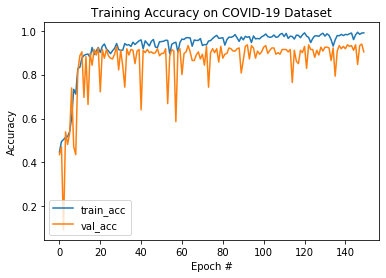

In [13]:
N = EPOCHS

plt.figure()

plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

In [14]:
from numpy import loadtxt
from tensorflow.keras.models import load_model
model = load_model('.mdl_wts.hdf5')

In [15]:
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)


# show a nicely formatted classification report
print(classification_report(testY, predIdxs,target_names=['normal','covid','virus']))

              precision    recall  f1-score   support

      normal       0.90      0.98      0.94       134
       covid       0.95      0.77      0.85        26
       virus       0.94      0.89      0.91       124

    accuracy                           0.92       284
   macro avg       0.93      0.88      0.90       284
weighted avg       0.92      0.92      0.92       284



In [16]:
score = model.evaluate(testX, testY,verbose=1)

print(score)

284/284 [==============================] - 1s 2ms/sample - loss: 0.3196 - accuracy: 0.9190
[0.31955366990935635, 0.9190141]


In [17]:
import itertools
pred_Y = model.predict(testX, batch_size = 8, verbose = True)
pred_Y

284/284 [==============================] - 0s 1ms/sample


array([[9.69229758e-01, 1.72295446e-12, 3.07701863e-02],
       [6.71702670e-03, 3.00312036e-06, 9.93279994e-01],
       [8.98208327e-06, 1.50303394e-13, 9.99991059e-01],
       [9.99997377e-01, 0.00000000e+00, 2.58137516e-06],
       [9.99999762e-01, 0.00000000e+00, 2.51313423e-07],
       [1.73527293e-03, 8.30332212e-08, 9.98264611e-01],
       [9.99968171e-01, 2.90033042e-32, 3.18747589e-05],
       [6.81995662e-05, 2.49411360e-11, 9.99931812e-01],
       [4.79596620e-03, 1.23218888e-06, 9.95202780e-01],
       [1.52076781e-02, 3.23627901e-05, 9.84759986e-01],
       [9.99970555e-01, 1.45119994e-32, 2.94460187e-05],
       [7.75577454e-03, 7.24376878e-06, 9.92237031e-01],
       [9.98596609e-01, 3.01294177e-21, 1.40336738e-03],
       [1.00000000e+00, 0.00000000e+00, 3.84209429e-08],
       [2.61039753e-03, 2.32843178e-07, 9.97389376e-01],
       [6.42187615e-07, 2.42692754e-16, 9.99999404e-01],
       [9.99996066e-01, 1.73586464e-38, 3.91911681e-06],
       [1.00000000e+00, 0.00000

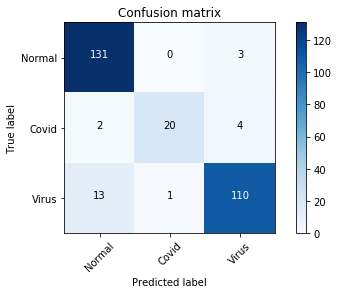

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names =['Normal','Covid','Virus']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(testX, batch_size=BS)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred_Y,axis = 1) 
# Convert validation observations to one hot vectors
# compute the confusion matrix
confusion_mtx = confusion_matrix(testY, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

In [19]:
import seaborn as sns
import pandas as pd

In [20]:
testY
y_test = pd.get_dummies(testY)
y_test = np.array(y_test)

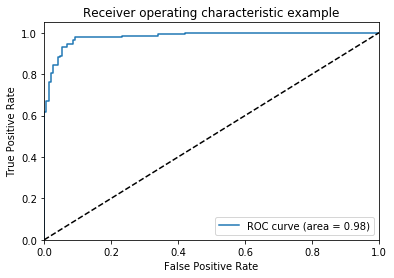

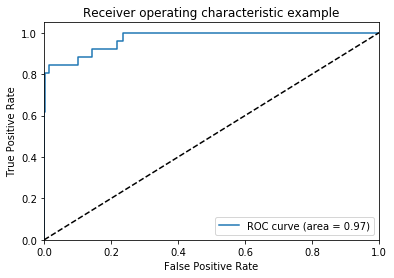

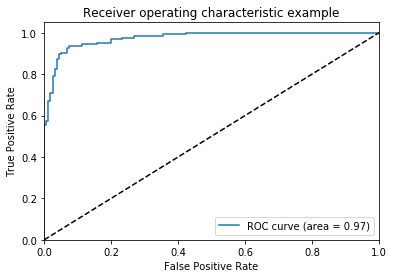

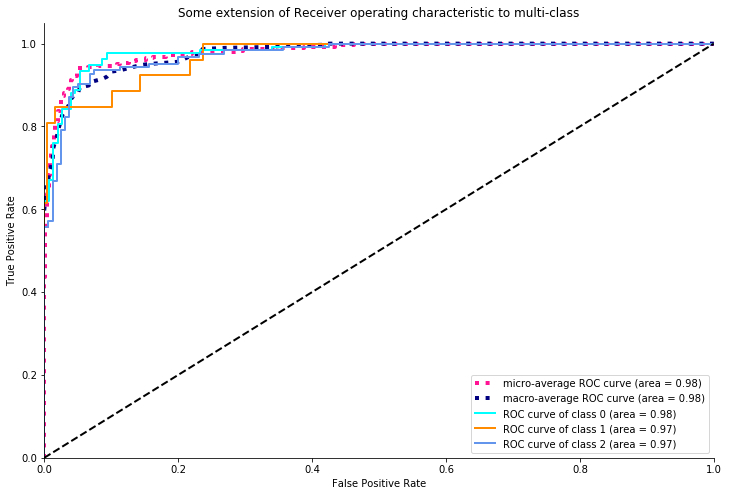

In [21]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


n_classes = 3

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_Y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_Y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
sns.despine()
plt.show()

In [ ]:
def specificity(y_true, y_pred):
    """
    param:
    y_pred - Predicted labels
    y_true - True labels 
    Returns:
    Specificity score
    """
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + K.epsilon())
    return specificity

In [ ]:
specificity(y_test, Y_pred)